## Drive

## Import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
from torchvision.models import densenet161, densenet121, resnet50 #resnet50, ResNet50_Weights, vgg16_bn, VGG16_BN_Weights, inception_v3, Inception_V3_Weights, densenet121
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from random import shuffle
from torchsummary import summary
from tqdm import tqdm
from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from torchvision import transforms
from PIL import Image
import random
import os
import gc
import time

## Check Device

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.3.0
True
NVIDIA GeForce RTX 2060
cuda:0


## Deterministic Execution

In [4]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Image loader class

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root, transform, is_valid_file, list_classes):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.list_classes = list_classes
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        ListFiles=[]
        for c in self.list_classes:
            listofFiles = os.listdir(os.path.join(self.root, c))
            for file in listofFiles:
                ListFiles.append((os.path.join(self.root, c, file), self.list_classes.index(c)))
        return ListFiles

    def loader_fc(self, path):
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader_fc(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

## Custom transformations

In [6]:
class MinMaxNormalize(object):
    def __init__(self, min_val=0.0, max_val=1.0):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, tensor):
        min_tensor = tensor.min()
        max_tensor = tensor.max()
        normalized_tensor = (tensor - min_tensor) / (max_tensor - min_tensor)
        normalized_tensor = normalized_tensor * (self.max_val - self.min_val) + self.min_val
        return normalized_tensor

class RandomTopBlackout:
    def __init__(self, max_blackout_percentage=1.0):
        self.max_blackout_percentage = max_blackout_percentage

    def __call__(self, img):

        blackout_percentage = np.random.uniform(0, self.max_blackout_percentage)
        blackout_height = int(img.shape[0] * blackout_percentage)

        img[:blackout_height, :, 0] = 0


        return img

## Definition of transformations for all the splits

In [7]:
data_transforms = {
    'train': transforms.Compose([
        #RandomTopBlackout(0.25),
        transforms.ToTensor(),                                              # convert to tensor -> (b,c,w,h) if type uint8 maps [0,255] to [0,1]
        transforms.ConvertImageDtype(torch.float32),                        # Images loaded as float64 convert to float32
        transforms.Resize((224,224)),                                       # Resize to match network input size
        MinMaxNormalize(min_val=0.0, max_val=1.0),                          # Normalize data between [0,1] if applied before ToTensor must normalize to [0,255]
        transforms.RandomRotation(15),                                      # Random rotation augumentation
        transforms.RandomHorizontalFlip(p=0.5),                             # Random flip augumentation
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Random translation
        #transforms.ElasticTransform(alpha=10.0, sigma=2.0, interpolation=InterpolationMode.BILINEAR, fill=0),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image channels using Imagenet meand and std

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Resize((224,224)),
        MinMaxNormalize(min_val=0.0, max_val=1.0),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Resize((224,224)),
        MinMaxNormalize(min_val=0.0, max_val=1.0),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Hyperparameters

In [8]:
# batch_size = 32
# epochs = 20
# learning_rate = 1e-4
# weight_decay = 1e-3
# class_weights = torch.tensor([3.779, 1.359], device=device)
# scheduler_step_size = 10
# scheduler_gamma = 0.5


batch_size = 16
epochs = 17
learning_rate = 1e-5
weight_decay = 1e-3
class_weights = torch.tensor([1.997, 0.666], device=device)
scheduler_step_size = 25
scheduler_gamma = 0.8



## Data paths

In [9]:
split_root = os.path.join(".", "data", "splitted")

train_path = os.path.join(split_root, "train")
val_path = os.path.join(split_root, "validation")
test_path = os.path.join(split_root, "test")

path = {'train': train_path,
        'val': val_path,
        'test': test_path}

## Training hold-out

### Dataset objects and dataloaders definition

In [10]:
image_datasets = {x: ImageDataset(root = path[x],
                    transform = data_transforms[x],
                    is_valid_file = True,
                    list_classes = ['benign', 'malignant'])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x],
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)
              for x in ['train', 'val', 'test']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

{'train': 2900, 'val': 992, 'test': 1001}


### Test Function

In [11]:
def test_model(model, dataloaders):
    model.eval()
    y_pred = torch.tensor([], device=device)
    y_true = torch.tensor([], device=device)
    with torch.inference_mode():
        for minibatch in dataloaders['test']:
            inputs, labels = minibatch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_pred = torch.hstack((y_pred, preds))
            y_true = torch.hstack((y_true, labels))
    y_pred = y_pred.cpu().numpy()
    y_true = y_true.cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant'])

    print(accuracy_score(y_true,y_pred))

### Training

#### Training loop

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, printEveryKEpochs=10):
    since = time.time()

    models_path = os.path.join(".", "models")

    best_acc = 0.0
    best_epoch = 0
    best_loss = float("inf")
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(total=len(dataloaders[phase]), desc=f'{phase}', unit='batch') as pbar:
                for minibatch in dataloaders[phase]:
                    inputs, labels = minibatch
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    pbar.update(1)

            torch.save(model.state_dict(), os.path.join(models_path, "model_params.pt"))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu()
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if (phase == 'val') and ((((epoch+1)%printEveryKEpochs) == 0) or (epoch+1 == num_epochs)):
                plt.figure(figsize=(15,6))
                plt.subplot(1,2,1)
                plt.xlim(0,num_epochs+1)
                plt.plot([i for i in range(1,epoch+2)], train_losses)
                plt.plot([i for i in range(1,epoch+2)], val_losses)
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("")
                plt.subplot(1,2,2)
                plt.xlim(0,num_epochs+1)
                plt.plot([i for i in range(1,epoch+2)], train_acc)
                plt.plot([i for i in range(1,epoch+2)], val_acc)
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.title("")
                plt.show()


            # deep copy the model
            if phase == 'val' and ((epoch_acc > best_acc) or ( (epoch_acc == best_acc) and  (epoch_loss < best_loss))):
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch+1
                torch.save(model.state_dict(), os.path.join(models_path, "best_params.pt"))

    print()

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.xlim(0,num_epochs+1)
    plt.plot([i for i in range(1,num_epochs+1)], train_losses)
    plt.plot([i for i in range(1,num_epochs+1)], val_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("")
    plt.subplot(1,2,2)
    plt.xlim(0,num_epochs+1)
    plt.plot([i for i in range(1,num_epochs+1)], train_acc)
    plt.plot([i for i in range(1,num_epochs+1)], val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("")
    plt.show()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best val epoch: {best_epoch}')

    # load best model weights
    model.load_state_dict(torch.load(os.path.join(models_path, "best_params.pt")))
    return model, best_epoch

#### Loading Model

<img src="./img/densenet161.png" width=650px height=400px style="display: block; margin-left: auto; margin-right: auto; width: 40%"/>

In [25]:
model = densenet161(weights="DEFAULT")
num_features = model.classifier.in_features

# Freeze all layers at the moment everything is unfreezed
for param in model.parameters():
    param.requires_grad = True


model.classifier = nn.Sequential(nn.Dropout(0.3),
                                nn.Linear(num_features, 2))

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

#### Training

Epoch 1/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.69batch/s]


train Loss: 0.5097 Acc: 0.7579


val: 100%|██████████| 62/62 [00:09<00:00,  6.25batch/s]


val Loss: 0.3378 Acc: 0.8589
Epoch 2/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.70batch/s]


train Loss: 0.3554 Acc: 0.8566


val: 100%|██████████| 62/62 [00:09<00:00,  6.61batch/s]


val Loss: 0.2553 Acc: 0.9244
Epoch 3/17
----------


train: 100%|██████████| 182/182 [01:44<00:00,  1.74batch/s]


train Loss: 0.2808 Acc: 0.9017


val: 100%|██████████| 62/62 [00:09<00:00,  6.59batch/s]


val Loss: 0.2504 Acc: 0.8659


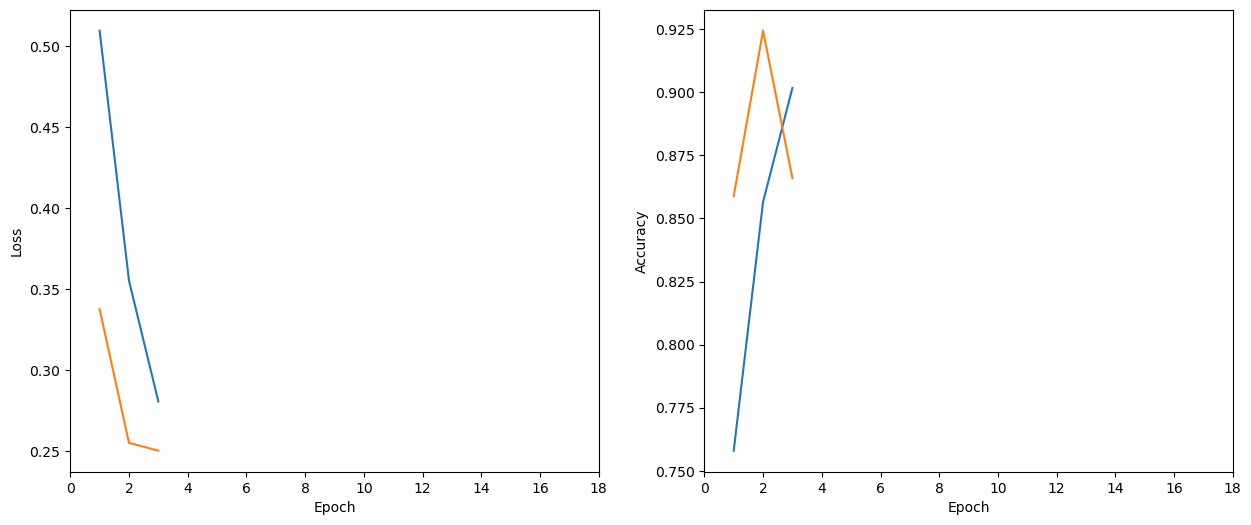

Epoch 4/17
----------


train: 100%|██████████| 182/182 [01:48<00:00,  1.67batch/s]


train Loss: 0.2137 Acc: 0.9224


val: 100%|██████████| 62/62 [00:09<00:00,  6.42batch/s]


val Loss: 0.1822 Acc: 0.9274
Epoch 5/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.69batch/s]


train Loss: 0.1754 Acc: 0.9355


val: 100%|██████████| 62/62 [00:09<00:00,  6.27batch/s]


val Loss: 0.1814 Acc: 0.9173
Epoch 6/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.70batch/s]


train Loss: 0.1394 Acc: 0.9514


val: 100%|██████████| 62/62 [00:09<00:00,  6.28batch/s]


val Loss: 0.1830 Acc: 0.9194


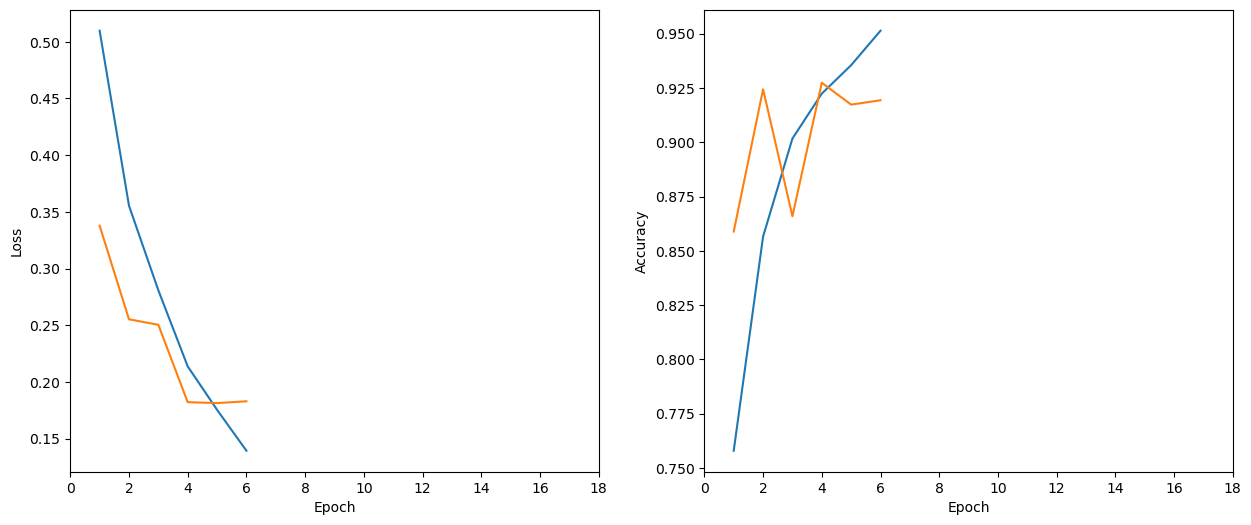

Epoch 7/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.69batch/s]


train Loss: 0.1228 Acc: 0.9597


val: 100%|██████████| 62/62 [00:09<00:00,  6.33batch/s]


val Loss: 0.1596 Acc: 0.9224
Epoch 8/17
----------


train: 100%|██████████| 182/182 [01:46<00:00,  1.71batch/s]


train Loss: 0.1075 Acc: 0.9617


val: 100%|██████████| 62/62 [00:09<00:00,  6.35batch/s]


val Loss: 0.1564 Acc: 0.9335
Epoch 9/17
----------


train: 100%|██████████| 182/182 [01:46<00:00,  1.71batch/s]


train Loss: 0.0941 Acc: 0.9710


val: 100%|██████████| 62/62 [00:09<00:00,  6.35batch/s]


val Loss: 0.1655 Acc: 0.9456


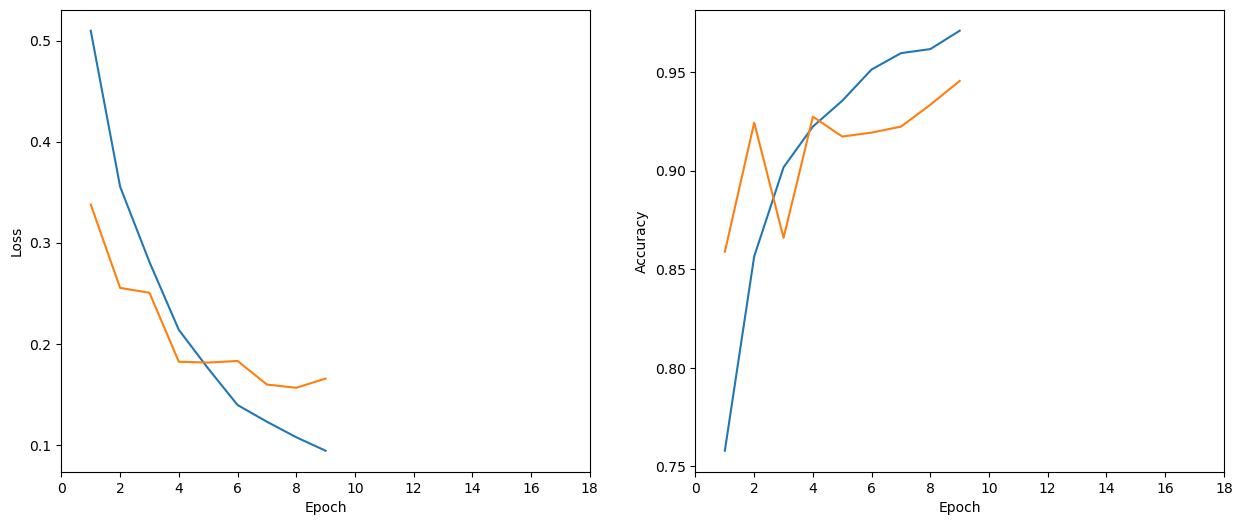

Epoch 10/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.69batch/s]


train Loss: 0.0837 Acc: 0.9728


val: 100%|██████████| 62/62 [00:09<00:00,  6.37batch/s]


val Loss: 0.1717 Acc: 0.9425
Epoch 11/17
----------


train: 100%|██████████| 182/182 [01:46<00:00,  1.70batch/s]


train Loss: 0.0708 Acc: 0.9762


val: 100%|██████████| 62/62 [00:09<00:00,  6.65batch/s]


val Loss: 0.1540 Acc: 0.9466
Epoch 12/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.70batch/s]


train Loss: 0.0648 Acc: 0.9817


val: 100%|██████████| 62/62 [00:09<00:00,  6.31batch/s]


val Loss: 0.1546 Acc: 0.9506


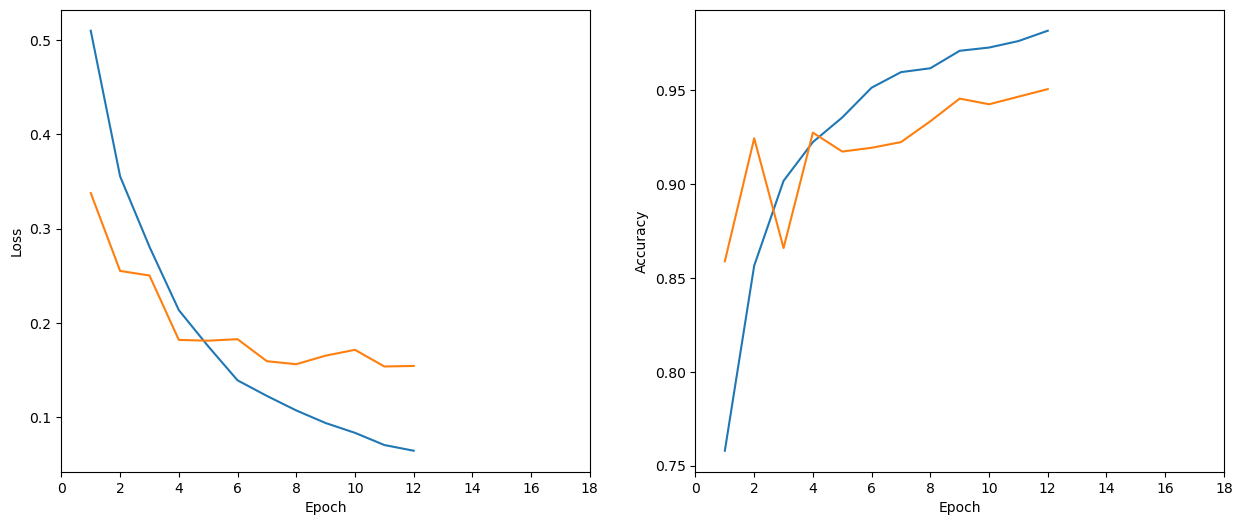

Epoch 13/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.70batch/s]


train Loss: 0.0476 Acc: 0.9876


val: 100%|██████████| 62/62 [00:09<00:00,  6.39batch/s]


val Loss: 0.1627 Acc: 0.9456
Epoch 14/17
----------


train: 100%|██████████| 182/182 [01:49<00:00,  1.67batch/s]


train Loss: 0.0443 Acc: 0.9879


val: 100%|██████████| 62/62 [00:09<00:00,  6.38batch/s]


val Loss: 0.1253 Acc: 0.9607
Epoch 15/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.69batch/s]


train Loss: 0.0430 Acc: 0.9845


val: 100%|██████████| 62/62 [00:09<00:00,  6.34batch/s]


val Loss: 0.1505 Acc: 0.9435


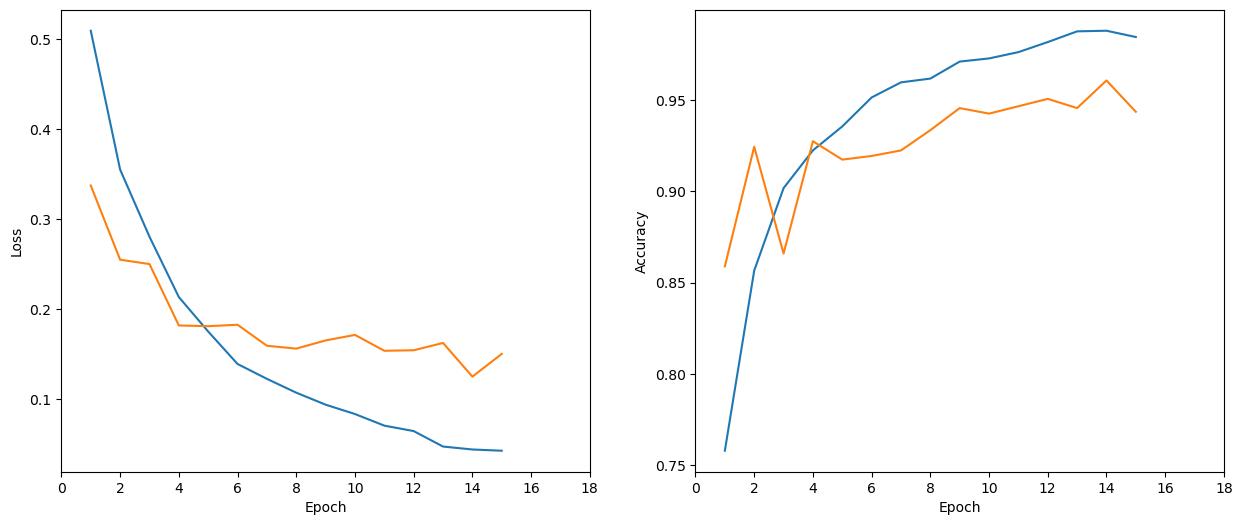

Epoch 16/17
----------


train: 100%|██████████| 182/182 [01:47<00:00,  1.70batch/s]


train Loss: 0.0536 Acc: 0.9828


val: 100%|██████████| 62/62 [00:09<00:00,  6.36batch/s]


val Loss: 0.1434 Acc: 0.9466
Epoch 17/17
----------


train: 100%|██████████| 182/182 [01:49<00:00,  1.67batch/s]


train Loss: 0.0359 Acc: 0.9900


val: 100%|██████████| 62/62 [00:10<00:00,  6.16batch/s]


val Loss: 0.1964 Acc: 0.9476


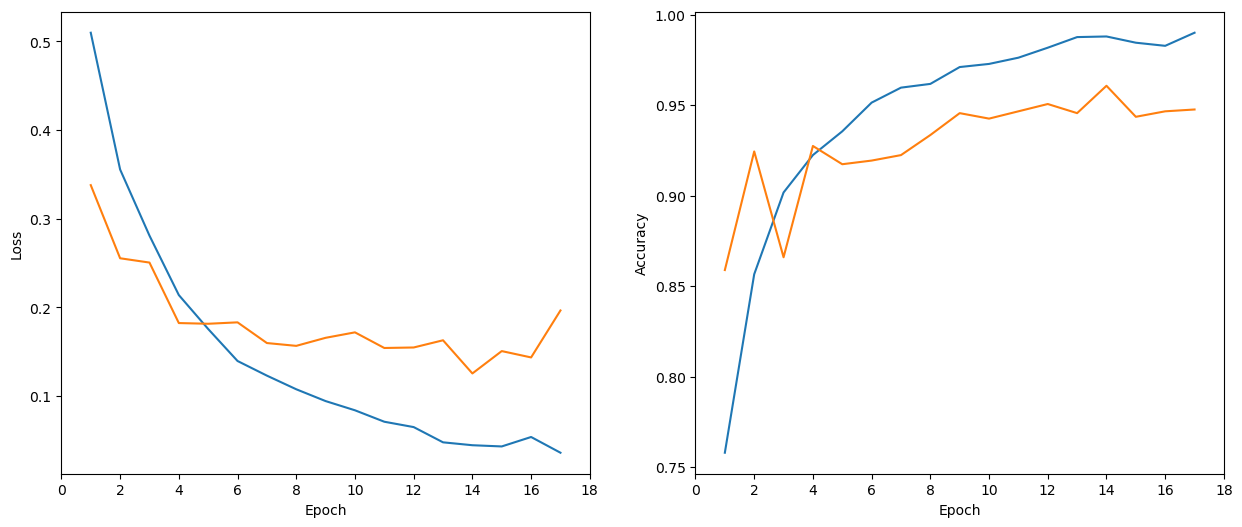

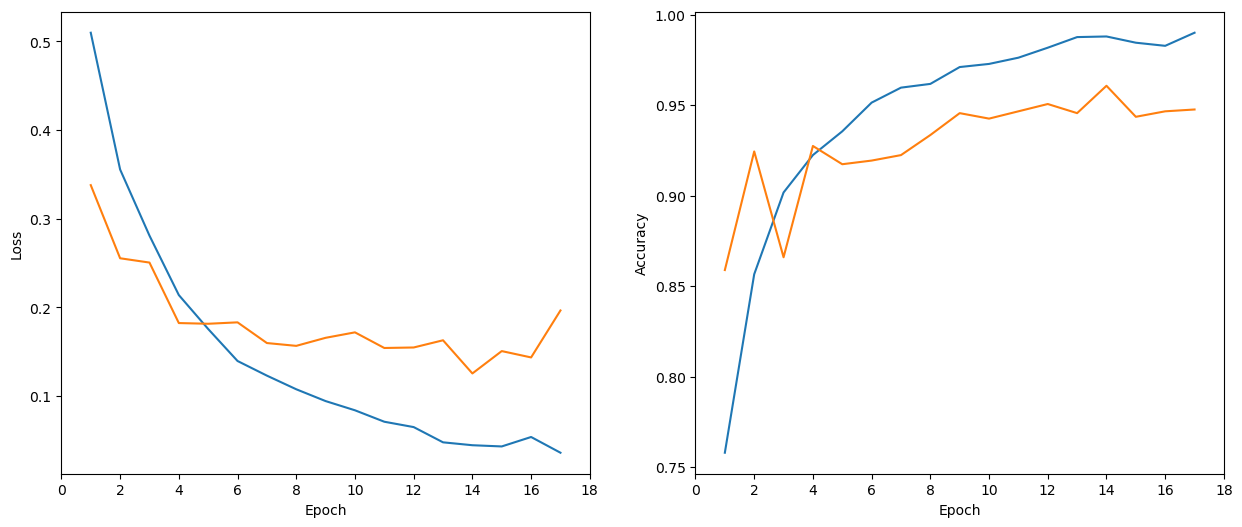

Training complete in 33m 22s
Best val Acc: 0.960685
Best val epoch: 14


In [26]:
loss = nn.CrossEntropyLoss(weight=class_weights)

#optimizer = optim.SGD(model.parameters(), weight_decay=weight_decay, lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

model, best_epoch = train_model(model, loss, optimizer, exp_lr_scheduler, num_epochs=epochs, printEveryKEpochs=3)

#### Load best model

In [27]:
model = densenet161()
num_features = model.classifier.in_features

model.classifier = nn.Sequential(nn.Dropout(0.3),
                                 nn.Linear(num_features, 2))

model.to(device)
model.load_state_dict(torch.load(os.path.join(".", "models", "best_params.pt")))

<All keys matched successfully>

#### Test

0.9590409590409591


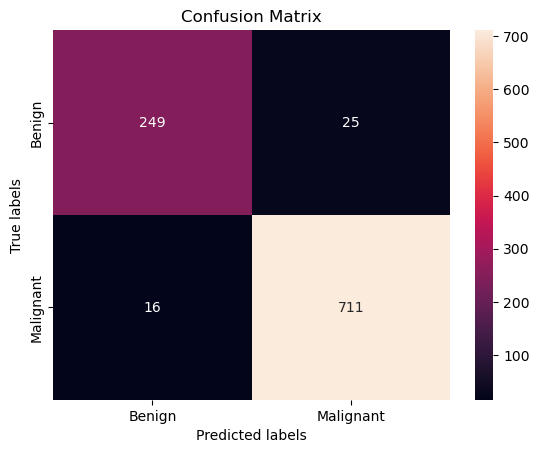

In [28]:
test_model(model, dataloaders)

## Train on training + validation with same iperparameters

### Reset GPU memory and random seed

In [17]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
gc.collect()
torch.cuda.empty_cache()

### New Dataset Object that loads more folders (train + validation or train + validation + test)

In [14]:
class GeneralizedImageDataset(Dataset):
    def __init__(self, root, transform, is_valid_file, list_classes, list_splits):
        self.root = root
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.list_classes = list_classes
        self.list_splits = list_splits
        self.samples = self.__get_samples()

    def __len__(self):
        return len(self.samples)

    def __get_samples(self):
        ListFiles=[]
        for split in self.list_splits:
            for c in self.list_classes:
                listofFiles = os.listdir(os.path.join(self.root, split, c))
                for file in listofFiles:
                    ListFiles.append((os.path.join(self.root, split, c, file), self.list_classes.index(c)))
        return ListFiles

    def loader_fc(self, path):
        img = np.load(path)
        return img

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        sample = self.loader_fc(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

### Create new ImageDataset and DataLoader objects

In [19]:
image_datasets_train_val = {
                    'train': GeneralizedImageDataset(root = split_root,
                    transform = data_transforms['train'],
                    is_valid_file = True,
                    list_classes = ['benign', 'malignant'],
                    list_splits = ["train", "validation"]
                    ),

                    "test": ImageDataset(root = path["test"],
                    transform = data_transforms["test"],
                    is_valid_file = True,
                    list_classes = ['benign', 'malignant'])
                    }

dataloaders_train_val = {x: DataLoader(image_datasets_train_val[x],
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)
              for x in ['train', 'test']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

{'train': 2900, 'test': 1001}


### New Training

#### New Training loop

In [15]:
def new_train_model(model, criterion, optimizer, scheduler, num_epochs, dataloader, printEveryKEpochs=3, out_model_name='model'):
    since = time.time()

    models_path = os.path.join(".", "models")
    train_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

        with tqdm(total=len(dataloader["train"]), desc=f'{"train"}', unit='batch') as pbar:
            for minibatch in dataloader["train"]:
                inputs, labels = minibatch
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    loss.backward()
                    optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                pbar.update(1)

        epoch_loss = running_loss / dataset_sizes['train']
        
        train_losses.append(epoch_loss)
    
        if (((epoch+1)%printEveryKEpochs) == 0) or (epoch+1 == num_epochs):
            plt.xlim(0,num_epochs+1)
            plt.plot([i for i in range(1,epoch+2)], train_losses)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("")
            plt.show()
         

        scheduler.step()
        torch.save(model.state_dict(), os.path.join(models_path, out_model_name+".pt"))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(torch.load(os.path.join(models_path, out_model_name+".pt")))
    return model

#### Load new model

In [21]:
model = densenet161(weights="DEFAULT")
num_features = model.classifier.in_features


# Freeze all layers at the moment everything is unfreezed
for param in model.parameters():
    param.requires_grad = True
    

model.classifier = nn.Sequential(nn.Dropout(p=0.3) ,nn.Linear(num_features, 2))

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

#### New Training

Epoch 1/14
----------


train: 100%|██████████| 244/244 [02:22<00:00,  1.71batch/s]


Epoch 2/14
----------


train: 100%|██████████| 244/244 [02:24<00:00,  1.69batch/s]


Epoch 3/14
----------


train: 100%|██████████| 244/244 [02:24<00:00,  1.69batch/s]


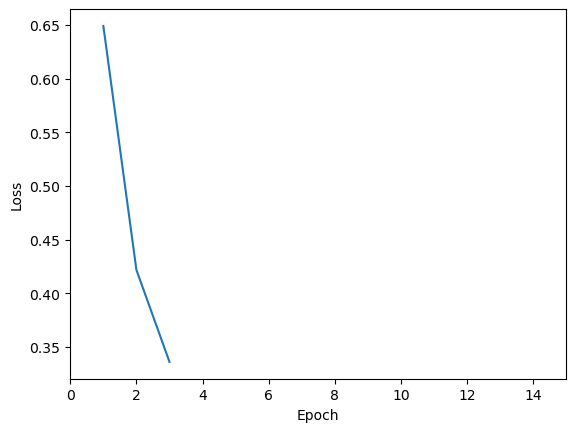

Epoch 4/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


Epoch 5/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


Epoch 6/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


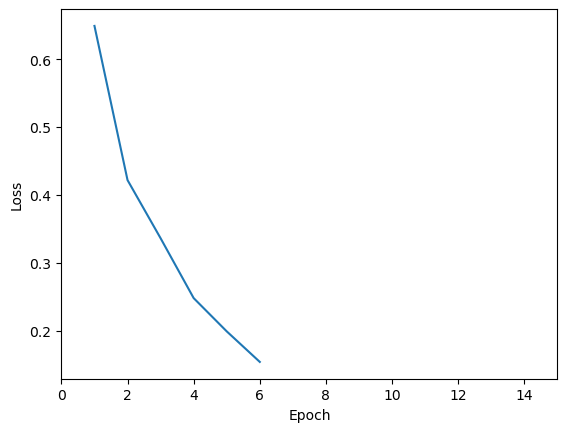

Epoch 7/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


Epoch 8/14
----------


train: 100%|██████████| 244/244 [02:24<00:00,  1.69batch/s]


Epoch 9/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


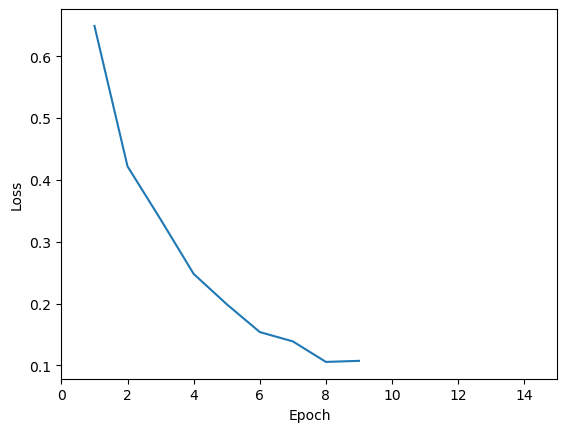

Epoch 10/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


Epoch 11/14
----------


train: 100%|██████████| 244/244 [02:24<00:00,  1.69batch/s]


Epoch 12/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


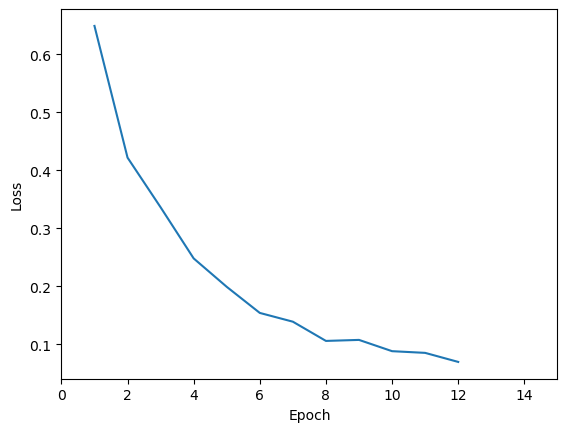

Epoch 13/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


Epoch 14/14
----------


train: 100%|██████████| 244/244 [02:23<00:00,  1.70batch/s]


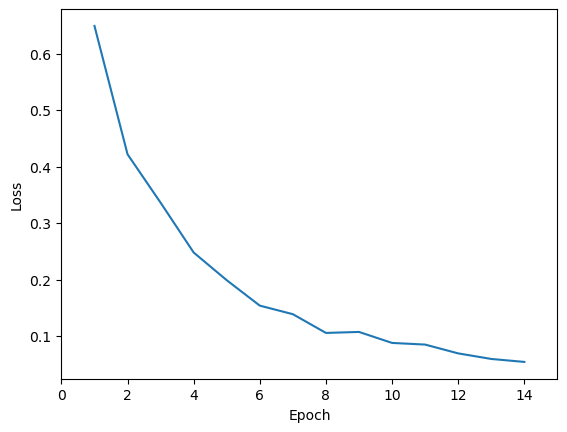

Training complete in 33m 35s


In [22]:
loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

model = new_train_model(model, loss, optimizer, exp_lr_scheduler, best_epoch, dataloaders_train_val, printEveryKEpochs=3, out_model_name='final_model_params')


#### New Test

0.954045954045954


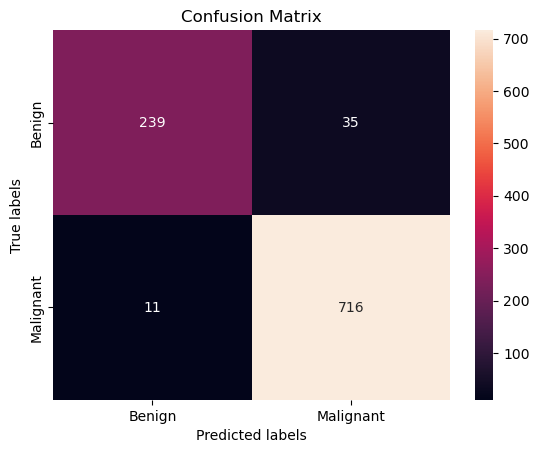

In [49]:
test_model(model, dataloaders_train_val)

## Train on everything for submission

### Reset GPU memory and random seed

In [31]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
gc.collect()
torch.cuda.empty_cache()

### Create new ImageDataset and DataLoader objects

In [32]:
image_dataset_final = {"train": GeneralizedImageDataset(root = split_root,
                    transform = data_transforms['train'],
                    is_valid_file = True,
                    list_classes = ['benign', 'malignant'],
                    list_splits = ["train", "validation", "test"]
                    )
                    }

dataloader_final = {"train":DataLoader(image_dataset_final["train"],
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True)}



print("train length:", len(image_dataset_final["train"]))

train length: 4893


### Final train

#### Load Final Model

In [33]:
model = densenet161(weights="DEFAULT")
num_features = model.classifier.in_features

model.classifier = nn.Sequential(nn.Dropout(p=0.3) ,nn.Linear(num_features, 2))

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

#### Final Training

Epoch 1/14
----------


train: 100%|██████████| 306/306 [03:06<00:00,  1.64batch/s]


Epoch 2/14
----------


train: 100%|██████████| 306/306 [03:11<00:00,  1.60batch/s]


Epoch 3/14
----------


train: 100%|██████████| 306/306 [03:12<00:00,  1.59batch/s]


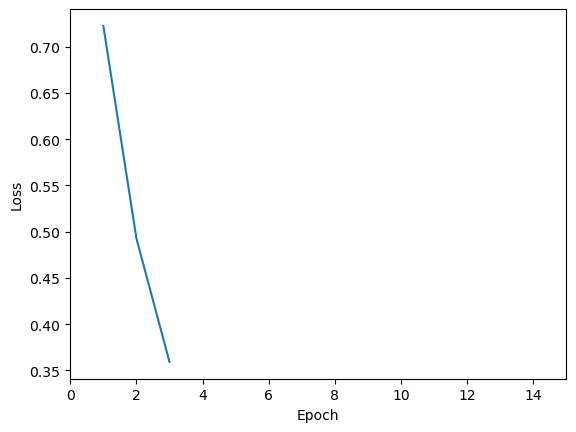

Epoch 4/14
----------


train: 100%|██████████| 306/306 [03:06<00:00,  1.64batch/s]


Epoch 5/14
----------


train: 100%|██████████| 306/306 [03:02<00:00,  1.68batch/s]


Epoch 6/14
----------


train: 100%|██████████| 306/306 [03:03<00:00,  1.67batch/s]


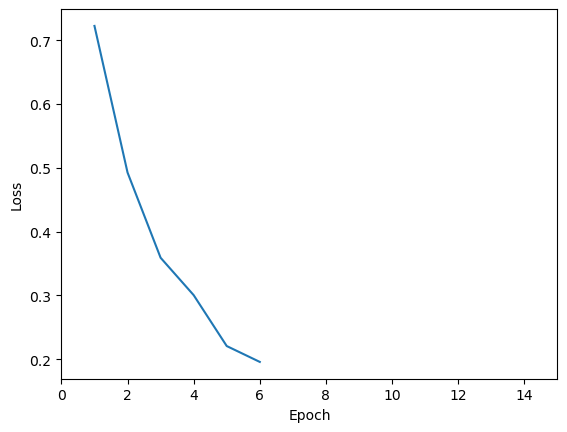

Epoch 7/14
----------


train: 100%|██████████| 306/306 [03:02<00:00,  1.68batch/s]


Epoch 8/14
----------


train: 100%|██████████| 306/306 [03:03<00:00,  1.67batch/s]


Epoch 9/14
----------


train: 100%|██████████| 306/306 [03:02<00:00,  1.68batch/s]


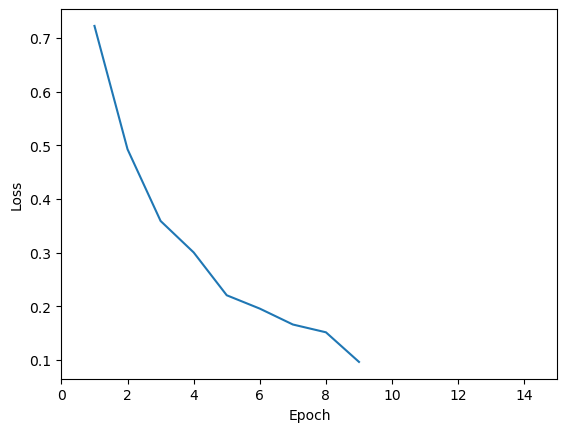

Epoch 10/14
----------


train: 100%|██████████| 306/306 [03:04<00:00,  1.66batch/s]


Epoch 11/14
----------


train: 100%|██████████| 306/306 [03:02<00:00,  1.67batch/s]


Epoch 12/14
----------


train: 100%|██████████| 306/306 [03:02<00:00,  1.68batch/s]


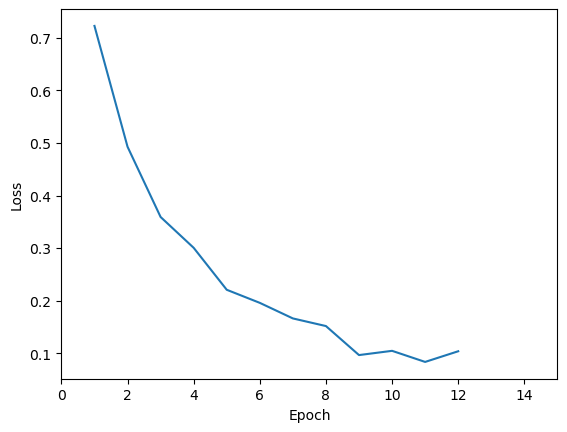

Epoch 13/14
----------


train: 100%|██████████| 306/306 [03:03<00:00,  1.66batch/s]


Epoch 14/14
----------


train: 100%|██████████| 306/306 [03:05<00:00,  1.65batch/s]


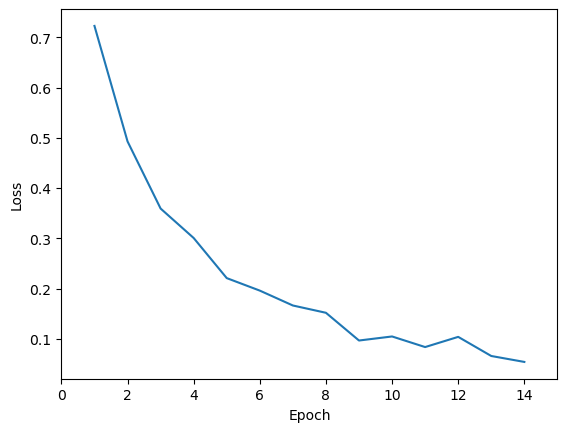

Training complete in 43m 15s


In [35]:
loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

model = new_train_model(model, loss, optimizer, exp_lr_scheduler, best_epoch, dataloader_final, out_model_name='submit_model_params')